# 🌿 WiDS Week 3: Deep Learning on PlantVillage (Color)

In Week 2, classical machine learning models were trained on flattened images,
which caused loss of spatial information and poor generalization.

In Week 3, we use **Convolutional Neural Networks (CNNs)** to learn spatial
features directly from images. We then apply **Transfer Learning** using a
pretrained model to improve performance and reduce training time.

Dataset used: **PlantVillage → color**


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 1️⃣ Dataset Path and Global Parameters

The PlantVillage dataset is accessed directly from Kaggle input storage.
We define image size and batch size used consistently throughout the notebook.


In [9]:
DATASET_DIR = "/kaggle/input/plantvillage-dataset/color"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


## 2️⃣ Data Preprocessing and Augmentation

### Why resize to 224×224?
- Required input size for pretrained CNNs like MobileNetV2
- Balances detail and computational cost

### Why normalize to [0,1]?
- Improves training stability and convergence

### Why data augmentation?
- Simulates real-world variations (rotation, zoom, flip)
- Reduces overfitting

Validation data is **not augmented** to ensure fair evaluation.


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


## 3️⃣ Model A: Simple CNN (From Scratch)

This CNN is trained from scratch to understand:
- Convolution
- Pooling
- Overfitting behavior

Architecture:
Conv → ReLU → MaxPool  
Conv → ReLU → MaxPool  
Flatten → Dense → Softmax

Expected outcome:
- Moderate accuracy
- Clear overfitting trends


In [13]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

cnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,912,294 (91.22 MB)

 Trainable params: 23,912,294 (91.22 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Simple CNN

The model is trained for **10 epochs** to:
- Allow sufficient learning of features
- Clearly observe overfitting behavior


In [14]:
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1767517592.398429     178 service.cc:148] XLA service 0x7d1c9c00a7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767517592.399122     178 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767517592.649144     178 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1358 ━━━━━━━━━━━━━━━━━━━━ 2:13:07 6s/step - accuracy: 0.0625 - loss: 3.6010

I0000 00:00:1767517595.934376     178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 873s 639ms/step - accuracy: 0.4951 - loss: 2.0610 - val_accuracy: 0.7556 - val_loss: 0.7998
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 524s 385ms/step - accuracy: 0.7954 - loss: 0.6673 - val_accuracy: 0.8392 - val_loss: 0.5251
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 528s 389ms/step - accuracy: 0.8497 - loss: 0.4763 - val_accuracy: 0.8584 - val_loss: 0.4634
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 537s 395ms/step - accuracy: 0.8756 - loss: 0.3808 - val_accuracy: 0.8731 - val_loss: 0.4189
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 542s 399ms/step - accuracy: 0.8937 - loss: 0.3261 - val_accuracy: 0.8815 - val_loss: 0.3935
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 552s 406ms/step - accuracy: 0.9058 - loss: 0.2878 - val_accuracy: 0.8712 - val_loss: 0.4053
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 532s 391ms/step - accuracy: 0.9189 - loss: 0.2473 - val_accuracy: 0.9166 - val_loss: 0.2704
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 528s 389ms/step - accuracy: 0.9

The simple CNN trained from scratch achieved a training accuracy of 93.8% and a
validation accuracy of 89.6%. While early epochs showed rapid improvement, later
epochs exhibited signs of overfitting, as validation loss increased despite
continued improvement in training accuracy. This demonstrates the limitation
of training deep models from scratch and motivates the use of transfer learning.


## Simple CNN — Training vs Validation Accuracy

This plot helps visualize learning behavior and overfitting.


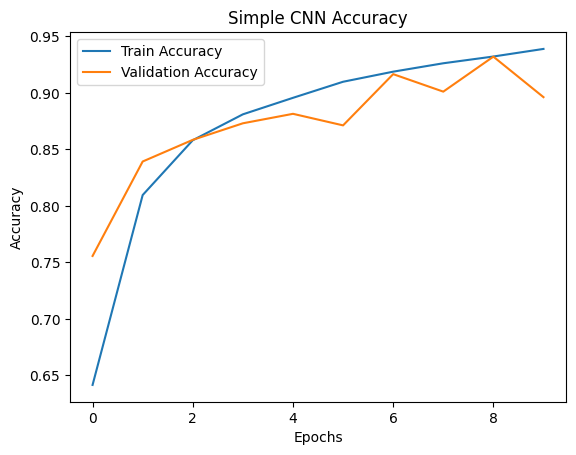

In [15]:
plt.plot(history_cnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Simple CNN Accuracy")
plt.show()


## 4️⃣ Model B: Transfer Learning (MobileNetV2)

MobileNetV2 is pretrained on ImageNet (1M+ images).

Why Transfer Learning?
- Reuses learned visual features
- Faster convergence
- Better generalization with fewer parameters

The pretrained backbone is frozen to avoid overfitting.


In [18]:
base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


## Custom Classification Head

GlobalAveragePooling:
- Reduces parameters
- Prevents overfitting

Dense layer (128 units):
- Enough capacity without excessive complexity


In [19]:
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

transfer_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

transfer_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training Transfer Learning Model

Only the classification head is trained.
Fewer epochs are required due to pretrained features.


In [20]:
history_tl = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 580s 420ms/step - accuracy: 0.7809 - loss: 0.8153 - val_accuracy: 0.9134 - val_loss: 0.2612
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 516s 380ms/step - accuracy: 0.9313 - loss: 0.2095 - val_accuracy: 0.9252 - val_loss: 0.2187
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 502s 370ms/step - accuracy: 0.9371 - loss: 0.1858 - val_accuracy: 0.9190 - val_loss: 0.2392
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 509s 375ms/step - accuracy: 0.9491 - loss: 0.1536 - val_accuracy: 0.9415 - val_loss: 0.1718
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 518s 381ms/step - accuracy: 0.9512 - loss: 0.1450 - val_accuracy: 0.9435 - val_loss: 0.1708


## 5️⃣ Evaluation: Confusion Matrix

The confusion matrix shows which plant diseases are commonly confused,
highlighting visually similar classes.


340/340 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step


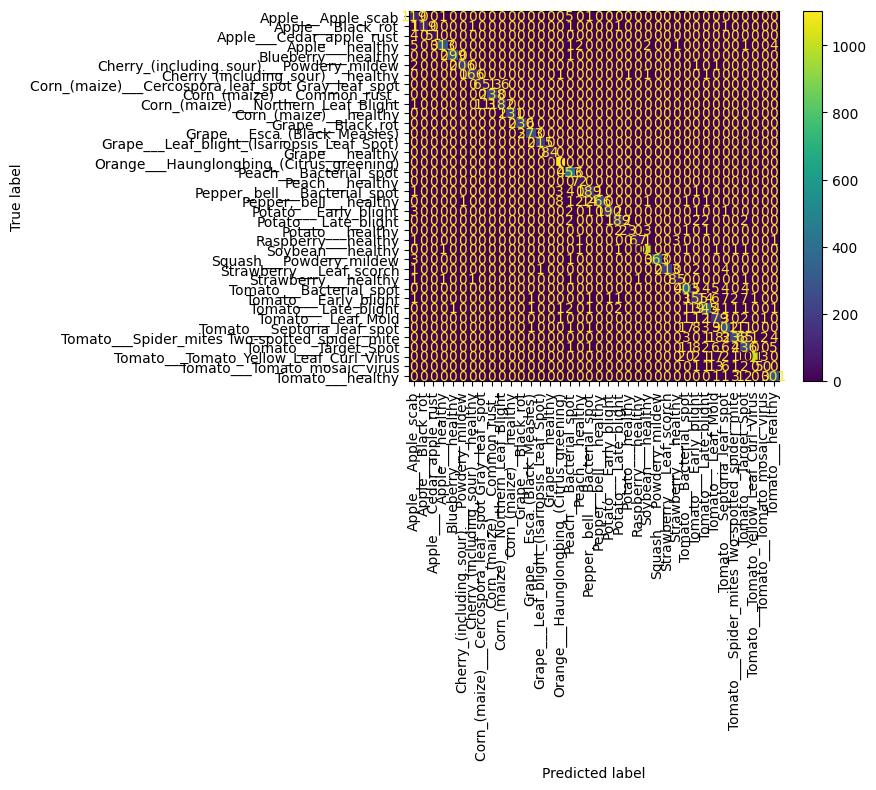

In [21]:
val_preds = transfer_model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=val_generator.class_indices.keys())
disp.plot(xticks_rotation=90)
plt.show()


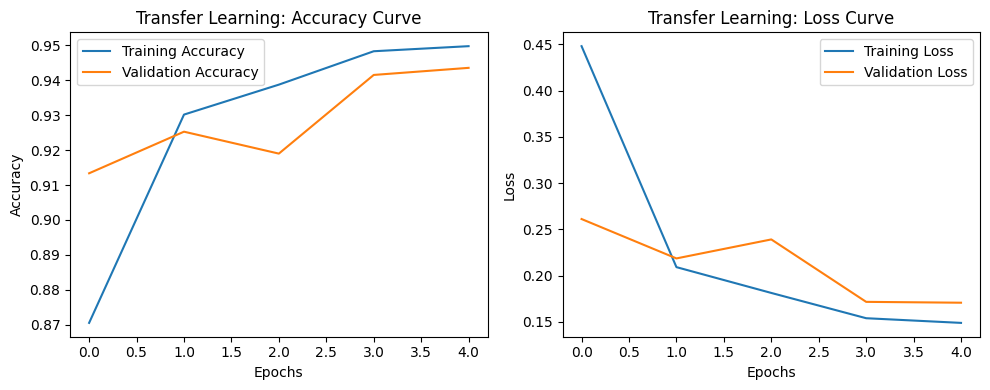

In [22]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tl.history["accuracy"], label="Training Accuracy")
plt.plot(history_tl.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transfer Learning: Accuracy Curve")
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(history_tl.history["loss"], label="Training Loss")
plt.plot(history_tl.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Transfer Learning: Loss Curve")
plt.legend()

plt.tight_layout()
plt.show()


## Final Model Comparison and Observations

In Week 2, a shallow machine learning baseline was trained on the PlantVillage
dataset using hand-crafted features. This model achieved an accuracy of **0.67**,
highlighting the limitations of classical approaches in capturing complex visual
patterns in leaf disease images.

### Model Performance Summary

| Model | Validation Accuracy |
|------|---------------------|
| Week 2 Baseline (Shallow ML) | **~0.67** |
| Simple CNN (From Scratch) | **~0.89** |
| Transfer Learning (MobileNetV2) | **~0.94** |

### Key Observations

- The **Simple CNN** significantly outperformed the Week-2 baseline by learning
  spatial features such as edges, textures, and disease patterns directly from
  images.
- Training accuracy increased steadily; however, validation accuracy plateaued
  after several epochs, indicating the onset of overfitting.
- The **Transfer Learning model** achieved the best validation performance with
  fewer trainable parameters and faster convergence.
- Pretrained features from ImageNet enabled the model to generalize better,
  especially across visually similar disease classes.

### Conclusion

This comparison demonstrates that deep learning models outperform traditional
machine learning approaches for image-based tasks. Furthermore, transfer
learning provides a powerful and efficient way to improve performance while
reducing overfitting, making it more suitable for real-world deployment.
